In [24]:
pip install yfinance PyPortfolioOpt matplotlib pandas numpy scipy scikit-learn

In [25]:
# Imports and Setup
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Portfolio Optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.objective_functions import L2_reg

from scipy.stats import skew, kurtosis
from numpy.linalg import eigh
import warnings

warnings.filterwarnings("ignore")

In [26]:
# Load Data
tickers = ['SPY', 'IWM', 'EFA', 'EEM', 'AGG', 'LQD', 'HYG', 'TLT', 'GLD', 'VNQ', 'DBC', 'VT', 'XLE', 'XLK', 'UUP']
start_date = "2008-07-01"
end_date = "2025-03-01"

prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"].dropna()
daily_returns = prices.pct_change().dropna()


[*********************100%***********************]  15 of 15 completed


In [27]:
# Download daily 3-month T-Bill rate (annualized) as proxy for risk-free rate
rf_data = yf.download("^IRX", start=start_date, end=end_date)["Close"] / 100
rf_data = rf_data.resample('B').ffill()
rf_daily = rf_data / 252
rf_daily.name = "RiskFreeRate"


[*********************100%***********************]  1 of 1 completed


In [28]:
# Random Matrix Theory (RMT) Covariance Filter
def rmt_denoised_covariance(returns, relax=1.0, label=""):
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals, eigenvecs = eigh(sample_cov)
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax
    filtered = np.clip(eigenvals, None, lambda_plus)
    print(f"[{label}] λ₊ = {lambda_plus:.4f} — Clipped {np.sum(eigenvals > lambda_plus)} eigenvalue(s)")
    return pd.DataFrame(eigenvecs @ np.diag(filtered) @ eigenvecs.T, index=returns.columns, columns=returns.columns)

In [29]:
# Performance Metrics Function
def compute_metrics(port_returns, label):
    metrics = {
        "Mean Return": port_returns.mean(),
        "Annual Return": port_returns.mean() * 252,
        "Geometric Return": (np.prod(1 + port_returns))**(252 / len(port_returns)) - 1,
        "Min Return": port_returns.min(),
        "Max Drawdown (%)": ((1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax() - 1).min() * 100,
        "Max 10-Day Drawdown (%)": port_returns.rolling(10).sum().min() * 100,
        "Sharpe Ratio": ((port_returns.mean() * 252) - (rf_daily.loc[port_returns.index].mean() * 252)) / (port_returns.std() * np.sqrt(252)),
        "Volatility": port_returns.std() * np.sqrt(252),
        "Skewness": skew(port_returns),
        "Kurtosis": kurtosis(port_returns),
        "VaR (%)": np.percentile(port_returns, 5) * 100,
        "CVaR (%)": port_returns[port_returns <= np.percentile(port_returns, 5)].mean() * 100,
    }
    return pd.Series(metrics, name=label), (1 + port_returns).cumprod()


In [30]:
# Gamma Sweep in RMT Out-of-Sample Regimes
gamma_grid = [0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
regimes = [("2008-07-01", "2018-12-31", "2019-01-01", "2025-03-01")]

rmt_gamma_metrics = {}

for train_start, train_end, test_start, test_end in regimes:
    train_prices = prices.loc[train_start:train_end]
    test_prices = prices.loc[test_start:test_end]
    train_returns = train_prices.pct_change().dropna()
    test_returns = test_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)
    rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

    for relax, relax_label in zip([1.2, 1.0, 1.4], ["RMT Relaxed (1.2)", "RMT Base (1.0)", "RMT High (1.4)"]):
        cov = rmt_denoised_covariance(train_returns, relax=relax, label=relax_label)
        rmt_gamma_metrics[relax_label] = {}

        for gamma in gamma_grid:
            try:
                ef = EfficientFrontier(mu_train, cov)
                ef.add_objective(L2_reg, gamma=gamma)
                ef.max_sharpe(risk_free_rate=rf_train_mean)
                weights = pd.Series(ef.clean_weights())
                returns = test_returns @ weights
                m, c = compute_metrics(returns, f"{relax_label} - Gamma {gamma}")
                rmt_gamma_metrics[relax_label][gamma] = (m, c)
            except Exception as e:
                print(f"Error optimizing {relax_label} at gamma={gamma}: {e}")


[RMT Relaxed (1.2)] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)
[RMT Base (1.0)] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)
[RMT High (1.4)] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)


In [32]:
# Display Gamma Sensitivity Tables for Each RMT Variant
for relax_label, gamma_data in rmt_gamma_metrics.items():
    gamma_table = pd.concat([m for m, _ in gamma_data.values()], axis=1)
    gamma_table.columns = [f"Gamma {g}" for g in gamma_data.keys()]
    print(f"\n--- Gamma Sensitivity Analysis for {relax_label} ---")
    display(gamma_table.round(6))



--- Gamma Sensitivity Analysis for RMT Relaxed (1.2) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
Annual Return,0.120492,0.120496,0.120493,0.120497,0.120495,0.120495
Geometric Return,0.115698,0.115699,0.115695,0.115697,0.115694,0.115694
Min Return,-0.085537,-0.085554,-0.08556,-0.08557,-0.085575,-0.085579
Max Drawdown (%),-25.302368,-25.306213,-25.307728,-25.310221,-25.311433,-25.312249
Max 10-Day Drawdown (%),-22.165482,-22.1683,-22.169514,-22.171531,-22.172497,-22.173086
Sharpe Ratio,Ticker ^IRX 0.649314 dtype: float64,Ticker ^IRX 0.649265 dtype: float64,Ticker ^IRX 0.649226 dtype: float64,Ticker ^IRX 0.649198 dtype: float64,Ticker ^IRX 0.649167 dtype: float64,Ticker ^IRX 0.649156 dtype: float64
Volatility,0.147956,0.147972,0.147977,0.147989,0.147993,0.147996
Skewness,-0.707889,-0.708037,-0.708117,-0.7082,-0.708259,-0.708301
Kurtosis,13.127092,13.128943,13.129949,13.130897,13.131614,13.132209



--- Gamma Sensitivity Analysis for RMT Base (1.0) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
Annual Return,0.120496,0.120497,0.120497,0.120499,0.120495,0.120498
Geometric Return,0.115699,0.115699,0.115697,0.115699,0.115694,0.115696
Min Return,-0.085548,-0.085561,-0.085567,-0.085574,-0.085576,-0.085583
Max Drawdown (%),-25.304996,-25.307908,-25.309523,-25.311139,-25.311541,-25.313153
Max 10-Day Drawdown (%),-22.167394,-22.169637,-22.170884,-22.172233,-22.17235,-22.173842
Sharpe Ratio,Ticker ^IRX 0.649283 dtype: float64,Ticker ^IRX 0.649242 dtype: float64,Ticker ^IRX 0.64921 dtype: float64,Ticker ^IRX 0.649194 dtype: float64,Ticker ^IRX 0.649168 dtype: float64,Ticker ^IRX 0.649153 dtype: float64
Volatility,0.147967,0.147979,0.147986,0.147993,0.147993,0.148001
Skewness,-0.707973,-0.708103,-0.708165,-0.708231,-0.708267,-0.708318
Kurtosis,13.128107,13.129825,13.130481,13.131375,13.1318,13.132277



--- Gamma Sensitivity Analysis for RMT High (1.4) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
Annual Return,0.120494,0.120495,0.120494,0.120494,0.120494,0.120494
Geometric Return,0.115701,0.115698,0.115696,0.115695,0.115694,0.115693
Min Return,-0.085529,-0.085548,-0.085557,-0.085566,-0.085574,-0.085578
Max Drawdown (%),-25.300515,-25.304966,-25.306984,-25.309302,-25.310917,-25.311944
Max 10-Day Drawdown (%),-22.16438,-22.167574,-22.169067,-22.171016,-22.172068,-22.172791
Sharpe Ratio,Ticker ^IRX 0.649352 dtype: float64,Ticker ^IRX 0.649277 dtype: float64,Ticker ^IRX 0.649241 dtype: float64,Ticker ^IRX 0.6492 dtype: float64,Ticker ^IRX 0.649175 dtype: float64,Ticker ^IRX 0.649157 dtype: float64
Volatility,0.14795,0.147968,0.147975,0.147984,0.14799,0.147994
Skewness,-0.707792,-0.707977,-0.708082,-0.708174,-0.708251,-0.708295
Kurtosis,13.125787,13.128095,13.129504,13.130525,13.131597,13.132136


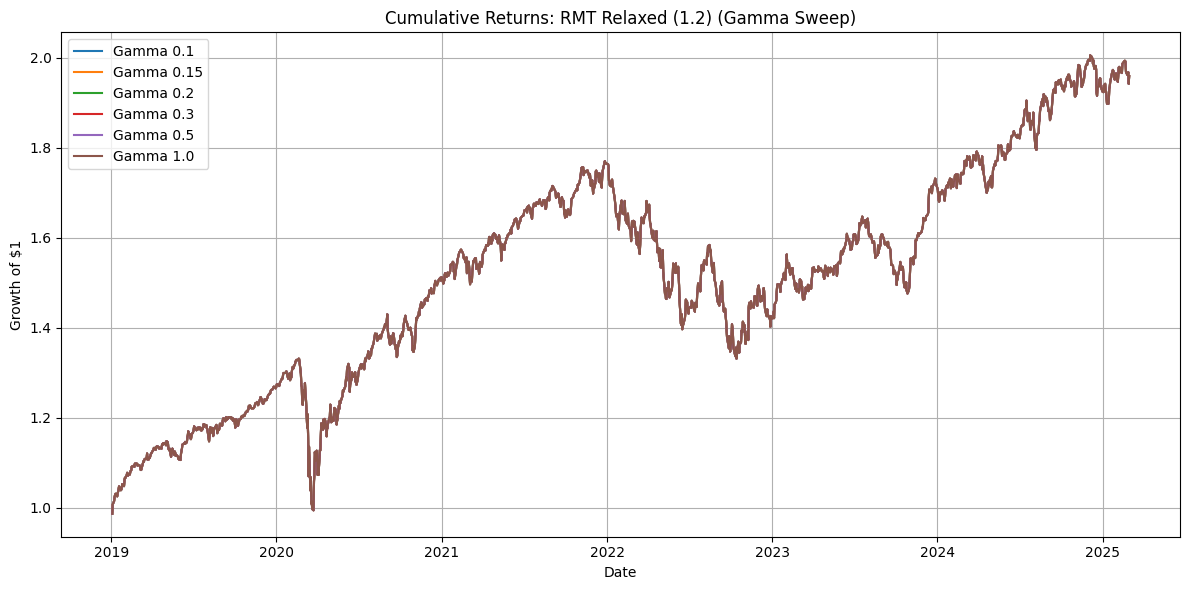

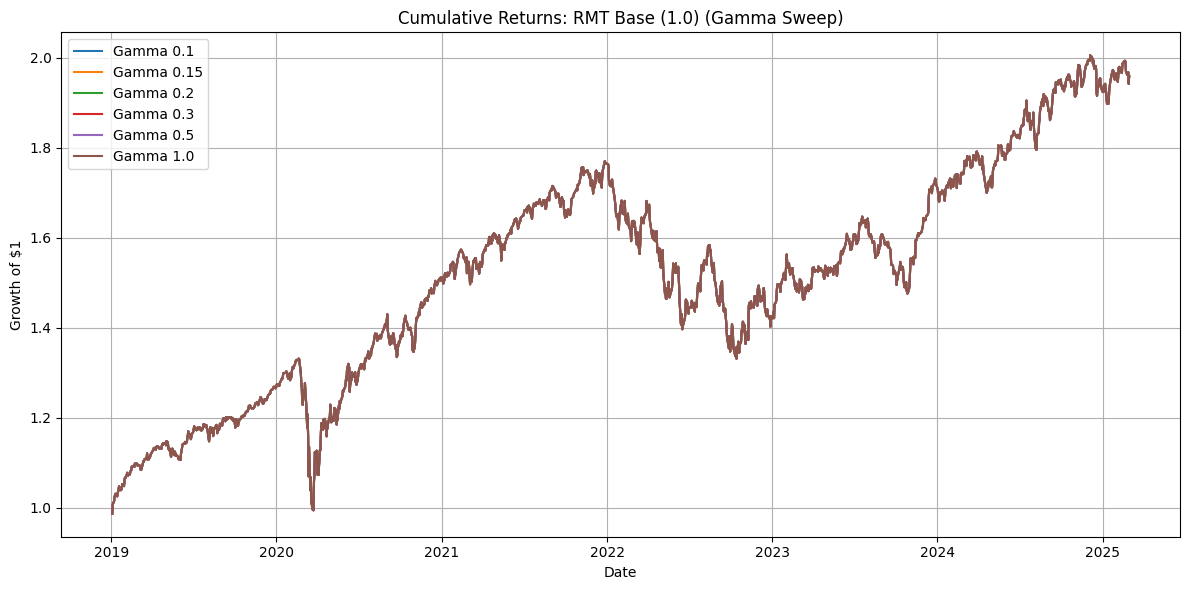

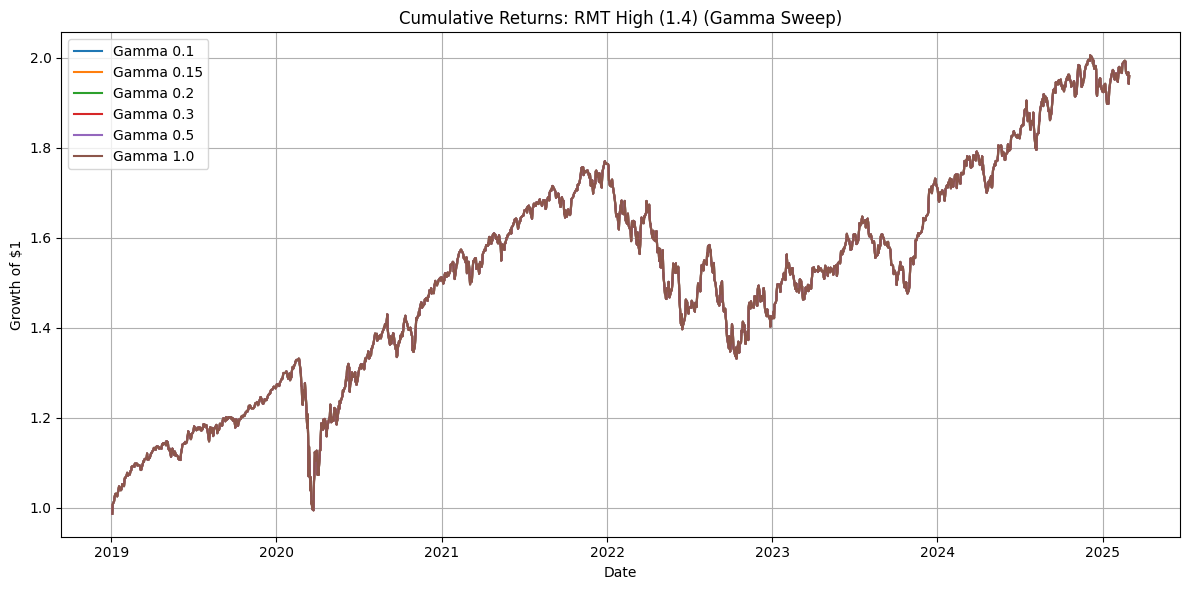

In [33]:
# Plot Cumulative Returns per Gamma for Each RMT Variant
for relax_label, gamma_data in rmt_gamma_metrics.items():
    plt.figure(figsize=(12, 6))
    for gamma, (_, curve) in gamma_data.items():
        plt.plot(curve, label=f"Gamma {gamma}")
    plt.title(f"Cumulative Returns: {relax_label} (Gamma Sweep)")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{relax_label.replace(' ', '_').replace('.', '')}_gamma_returns.png", dpi=300)
    plt.show()


In [42]:
# Static Models on Full Period
metrics, curves = {}, {}
mu_full = mean_historical_return(prices, frequency=252)
subset = daily_returns.columns[:10]
rf_full_mean = float(rf_daily.loc[prices.index].mean())

# MVO-LW
cov_lw = CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu_full, cov_lw)
ef.add_objective(L2_reg, gamma=.1)
ef.max_sharpe(risk_free_rate=rf_full_mean)
weights_lw = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_lw, "MVO-LW")
metrics["MVO-LW (Static)"] = m
curves["MVO-LW (Static)"] = c

# Equal-Weighted
equal_weights = pd.Series(1 / len(tickers), index=tickers)
m, c = compute_metrics(daily_returns @ equal_weights, "Equal-Weighted")
metrics["Equal-Weighted"] = m
curves["Equal-Weighted"] = c

# MVO-Naive
sample_cov_df = pd.DataFrame(np.cov(daily_returns, rowvar=False), index=daily_returns.columns, columns=daily_returns.columns)
ef = EfficientFrontier(mu_full, sample_cov_df)
ef.max_sharpe(risk_free_rate=rf_full_mean)
weights_naive = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_naive, "MVO-Naive")
metrics["MVO-Naive"] = m
curves["MVO-Naive"] = c

# LW Subset
mu_sub = mean_historical_return(prices[subset], frequency=252)
cov_sub = CovarianceShrinkage(prices[subset]).ledoit_wolf()
rf_subset_mean = float(rf_daily.loc[prices[subset].index].mean())
ef = EfficientFrontier(mu_sub, cov_sub)
ef.add_objective(L2_reg, gamma=.1)
ef.max_sharpe(risk_free_rate=rf_subset_mean)
weights_sub = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns[subset] @ weights_sub, "LW Subset")
metrics["LW Subset"] = m
curves["LW Subset"] = c


In [43]:
for relax_label, gamma_data in rmt_gamma_metrics.items():
    # Select gamma with the highest Sharpe Ratio
    best_gamma = max(gamma_data.items(), key=lambda x: x[1][0]["Sharpe Ratio"].item())[0]
    m, c = gamma_data[best_gamma]
    metrics[f"{relax_label} (Best γ={best_gamma})"] = m
    curves[f"{relax_label} (Best γ={best_gamma})"] = c

In [44]:
# ETF Benchmark Metrics
etf_metrics, etf_curves = {}, {}
for ticker in daily_returns.columns:
    port_returns = daily_returns[ticker]
    m, c = compute_metrics(port_returns, ticker)
    etf_metrics[ticker] = m
    etf_curves[ticker] = c

In [45]:
# Combine all metrics
oos_table = pd.concat(metrics.values(), axis=1).round(6)
etf_table = pd.concat(etf_metrics.values(), axis=1).round(6)
metrics_table = pd.concat(list(metrics.values()) + list(etf_metrics.values()), axis=1).round(6)

print("\n--- Final Out-of-Sample Model Comparison Table ---")
display(oos_table)
print("\n--- Individual ETF Benchmark Performance ---")
display(etf_table)
print("\n--- Full Metrics Table: Models + ETFs ---")
display(metrics_table)


--- Final Out-of-Sample Model Comparison Table ---


,MVO-LW,Equal-Weighted,MVO-Naive,LW Subset,RMT Relaxed (1.2) - Gamma 0.1,RMT Base (1.0) - Gamma 0.1,RMT High (1.4) - Gamma 0.1
Mean Return,0.000384,0.000293,0.000219,0.000326,0.000478,0.000478,0.000478
Annual Return,0.096763,0.073716,0.055305,0.082168,0.120492,0.120496,0.120494
Geometric Return,0.095458,0.067262,0.055836,0.080037,0.115698,0.115699,0.115701
Min Return,-0.060379,-0.075298,-0.034211,-0.059289,-0.085537,-0.085548,-0.085529
Max Drawdown (%),-23.169479,-32.633024,-7.086702,-23.525501,-25.302368,-25.304996,-25.300515
Max 10-Day Drawdown (%),-15.304183,-22.892123,-5.59547,-18.307661,-22.165482,-22.167394,-22.16438
Sharpe Ratio,Ticker ^IRX 0.807745 dtype: float64,Ticker ^IRX 0.474644 dtype: float64,Ticker ^IRX 0.997401 dtype: float64,Ticker ^IRX 0.695982 dtype: float64,Ticker ^IRX 0.649314 dtype: float64,Ticker ^IRX 0.649283 dtype: float64,Ticker ^IRX 0.649352 dtype: float64
Volatility,0.105596,0.131146,0.04395,0.101583,0.147956,0.147967,0.14795
Skewness,-0.01741,-0.236979,-0.307052,-0.131412,-0.707889,-0.707973,-0.707792
Kurtosis,12.57629,15.128749,20.321641,12.753141,13.127092,13.128107,13.125787



--- Individual ETF Benchmark Performance ---


,AGG,DBC,EEM,EFA,GLD,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000117,-0.000065,0.000231,0.000257,0.000307,0.000233,0.000451,0.000185,0.000519,0.000164,0.000113,0.00046,0.000385,0.00032,0.00071
Annual Return,0.029392,-0.016305,0.058115,0.064776,0.077353,0.058823,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.028259,-0.034136,0.019438,0.041099,0.064786,0.05378,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.068395,-0.079444,-0.161662,-0.111632,-0.087808,-0.080975,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195137,-0.12138,-0.201411,-0.13814
Max Drawdown (%),-18.432926,-76.362636,-58.678441,-52.789198,-45.555013,-30.35962,-53.884095,-24.954903,-47.16522,-48.351137,-22.190943,-66.125075,-49.757513,-71.26278,-44.225694
Max 10-Day Drawdown (%),-10.339845,-24.596081,-41.000799,-32.881856,-23.386499,-21.699243,-38.910084,-23.172085,-30.114958,-11.06321,-9.64988,-38.630288,-31.489315,-60.48782,-25.918984
Sharpe Ratio,Ticker ^IRX 0.325454 dtype: float64,Ticker ^IRX -0.144965 dtype: float64,Ticker ^IRX 0.166896 dtype: float64,Ticker ^IRX 0.241008 dtype: float64,Ticker ^IRX 0.386063 dtype: float64,Ticker ^IRX 0.41684 dtype: float64,Ticker ^IRX 0.40806 dtype: float64,Ticker ^IRX 0.385914 dtype: float64,Ticker ^IRX 0.598895 dtype: float64,Ticker ^IRX 0.19094 dtype: float64,Ticker ^IRX 0.212743 dtype: float64,Ticker ^IRX 0.344664 dtype: float64,Ticker ^IRX 0.411732 dtype: float64,Ticker ^IRX 0.224137 dtype: float64,Ticker ^IRX 0.721479 dtype: float64
Volatility,0.055071,0.19159,0.279496,0.221186,0.170658,0.113603,0.25048,0.091272,0.199219,0.156517,0.080355,0.303209,0.207953,0.308059,0.23213
Skewness,-2.010748,-0.44381,0.686142,-0.032932,-0.08503,0.764673,-0.379371,0.053317,-0.082265,0.096352,-0.018817,-0.021185,-0.344441,-0.273789,-0.015038
Kurtosis,52.399876,3.618405,21.604134,14.388503,7.459103,41.676754,6.467476,57.594053,14.683921,3.131752,3.642579,17.283123,12.812962,12.761112,9.376887



--- Full Metrics Table: Models + ETFs ---


,MVO-LW,Equal-Weighted,MVO-Naive,LW Subset,RMT Relaxed (1.2) - Gamma 0.1,RMT Base (1.0) - Gamma 0.1,RMT High (1.4) - Gamma 0.1,AGG,DBC,EEM,...,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000384,0.000293,0.000219,0.000326,0.000478,0.000478,0.000478,0.000117,-0.000065,0.000231,...,0.000233,0.000451,0.000185,0.000519,0.000164,0.000113,0.00046,0.000385,0.00032,0.00071
Annual Return,0.096763,0.073716,0.055305,0.082168,0.120492,0.120496,0.120494,0.029392,-0.016305,0.058115,...,0.058823,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.095458,0.067262,0.055836,0.080037,0.115698,0.115699,0.115701,0.028259,-0.034136,0.019438,...,0.05378,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.060379,-0.075298,-0.034211,-0.059289,-0.085537,-0.085548,-0.085529,-0.068395,-0.079444,-0.161662,...,-0.080975,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195137,-0.12138,-0.201411,-0.13814
Max Drawdown (%),-23.169479,-32.633024,-7.086702,-23.525501,-25.302368,-25.304996,-25.300515,-18.432926,-76.362636,-58.678441,...,-30.35962,-53.884095,-24.954903,-47.16522,-48.351137,-22.190943,-66.125075,-49.757513,-71.26278,-44.225694
Max 10-Day Drawdown (%),-15.304183,-22.892123,-5.59547,-18.307661,-22.165482,-22.167394,-22.16438,-10.339845,-24.596081,-41.000799,...,-21.699243,-38.910084,-23.172085,-30.114958,-11.06321,-9.64988,-38.630288,-31.489315,-60.48782,-25.918984
Sharpe Ratio,Ticker ^IRX 0.807745 dtype: float64,Ticker ^IRX 0.474644 dtype: float64,Ticker ^IRX 0.997401 dtype: float64,Ticker ^IRX 0.695982 dtype: float64,Ticker ^IRX 0.649314 dtype: float64,Ticker ^IRX 0.649283 dtype: float64,Ticker ^IRX 0.649352 dtype: float64,Ticker ^IRX 0.325454 dtype: float64,Ticker ^IRX -0.144965 dtype: float64,Ticker ^IRX 0.166896 dtype: float64,...,Ticker ^IRX 0.41684 dtype: float64,Ticker ^IRX 0.40806 dtype: float64,Ticker ^IRX 0.385914 dtype: float64,Ticker ^IRX 0.598895 dtype: float64,Ticker ^IRX 0.19094 dtype: float64,Ticker ^IRX 0.212743 dtype: float64,Ticker ^IRX 0.344664 dtype: float64,Ticker ^IRX 0.411732 dtype: float64,Ticker ^IRX 0.224137 dtype: float64,Ticker ^IRX 0.721479 dtype: float64
Volatility,0.105596,0.131146,0.04395,0.101583,0.147956,0.147967,0.14795,0.055071,0.19159,0.279496,...,0.113603,0.25048,0.091272,0.199219,0.156517,0.080355,0.303209,0.207953,0.308059,0.23213
Skewness,-0.01741,-0.236979,-0.307052,-0.131412,-0.707889,-0.707973,-0.707792,-2.010748,-0.44381,0.686142,...,0.764673,-0.379371,0.053317,-0.082265,0.096352,-0.018817,-0.021185,-0.344441,-0.273789,-0.015038
Kurtosis,12.57629,15.128749,20.321641,12.753141,13.127092,13.128107,13.125787,52.399876,3.618405,21.604134,...,41.676754,6.467476,57.594053,14.683921,3.131752,3.642579,17.283123,12.812962,12.761112,9.376887


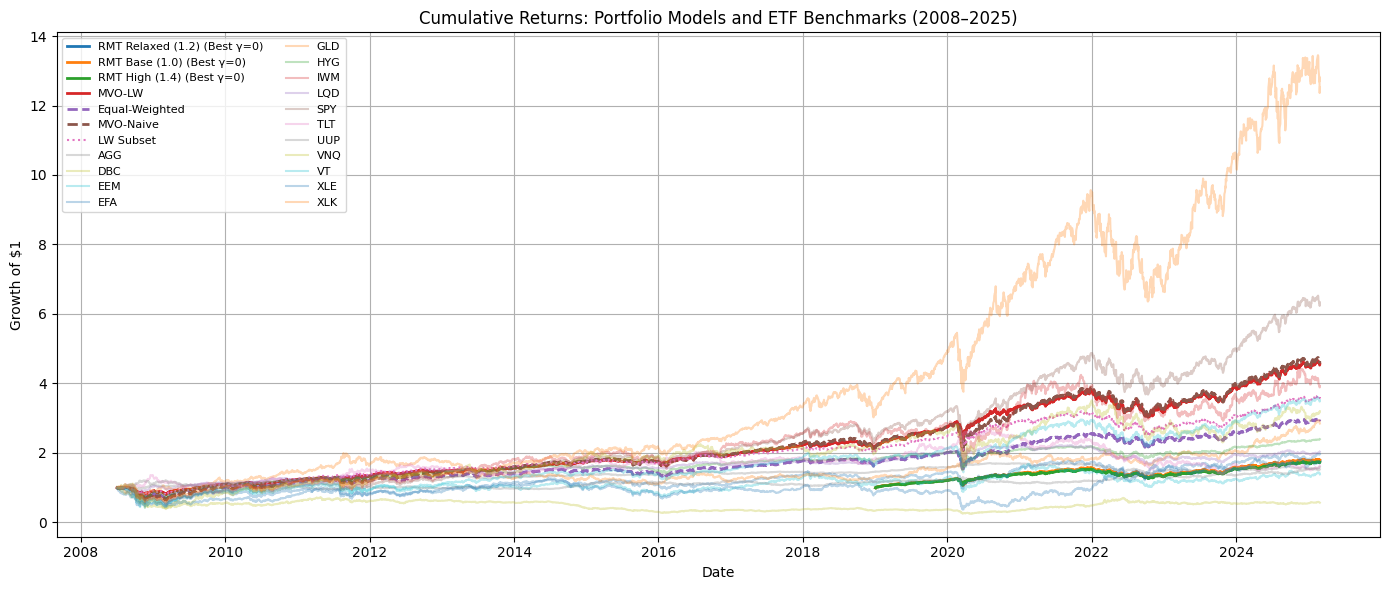

In [17]:
plt.figure(figsize=(14, 6))

# Dynamically add RMT best-gamma curves
for label in curves:
    if "RMT" in label and "Best γ=" in label:
        plt.plot(curves[label], label=label, linewidth=2)

plt.plot(curves["MVO-LW (Static)"], label="MVO-LW", linewidth=2)
plt.plot(curves["Equal-Weighted"], label="Equal-Weighted", linewidth=2, linestyle="--")
plt.plot(curves["MVO-Naive"], label="MVO-Naive", linestyle="--", linewidth=2)
plt.plot(curves["LW Subset"], label="LW Subset", linestyle=":")

for ticker, curve in etf_curves.items():
    plt.plot(curve, label=ticker, alpha=0.3)

plt.title("Cumulative Returns: Portfolio Models and ETF Benchmarks (2008–2025)")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend(fontsize=8, loc="upper left", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_returns_plot.png", dpi=300)
plt.show()



In [18]:
print("\n--- Final Weights for Best-Gamma RMT Portfolios ---")

for relax, label in zip([1.2, 1.0, 1.4], ["RMT Relaxed (1.2)", "RMT Base (1.0)", "RMT High (1.4)"]):
    gamma_data = rmt_gamma_metrics[label]
    best_gamma = max(gamma_data.items(), key=lambda x: x[1][0]["Sharpe Ratio"].item())[0]

    # Rebuild training data
    train_start, train_end = "2008-07-01", "2018-12-31"
    train_prices = prices.loc[train_start:train_end]
    train_returns = train_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)
    rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

    # Get covariance matrix and weights for best gamma
    cov = rmt_denoised_covariance(train_returns, relax=relax, label=label)
    ef = EfficientFrontier(mu_train, cov)
    ef.add_objective(L2_reg, gamma=best_gamma)
    ef.max_sharpe(risk_free_rate=rf_train_mean)
    weights = pd.Series(ef.clean_weights()).sort_values(ascending=False).round(4)

    print(f"\nFinal Weights ({label}, Best γ={best_gamma}):")
    print(weights)


--- Final Weights for Best-Gamma RMT Portfolios ---
[RMT Relaxed (1.2)] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)

Final Weights (RMT Relaxed (1.2), Best γ=0):
AGG    0.3592
XLK    0.1789
SPY    0.1308
UUP    0.0975
LQD    0.0500
GLD    0.0498
HYG    0.0480
IWM    0.0393
TLT    0.0329
VNQ    0.0137
DBC    0.0000
EFA    0.0000
EEM    0.0000
VT     0.0000
XLE    0.0000
dtype: float64
[RMT Base (1.0)] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)

Final Weights (RMT Base (1.0), Best γ=0):
AGG    0.3418
XLK    0.1746
SPY    0.1550
UUP    0.0844
HYG    0.0511
LQD    0.0508
GLD    0.0507
IWM    0.0437
TLT    0.0279
VNQ    0.0200
DBC    0.0000
EFA    0.0000
EEM    0.0000
VT     0.0000
XLE    0.0000
dtype: float64
[RMT High (1.4)] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)

Final Weights (RMT High (1.4), Best γ=0):
AGG    0.3735
XLK    0.1827
SPY    0.1101
UUP    0.1086
LQD    0.0492
GLD    0.0484
HYG    0.0454
TLT    0.0371
IWM    0.0359
VNQ    0.0092
DBC    0.0000
EFA    0.0000
EEM    0.0000
VT     0.0000
X

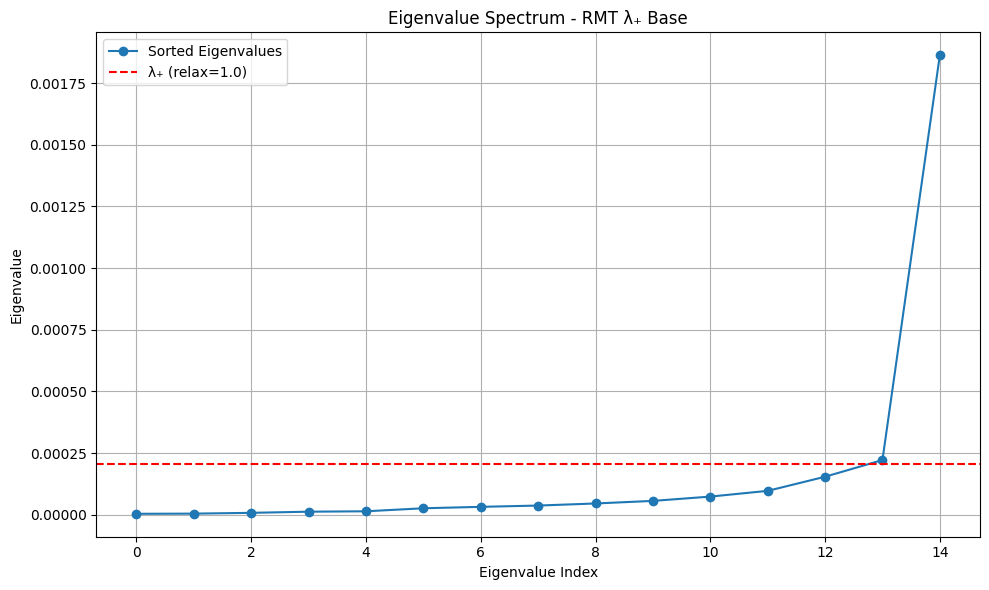

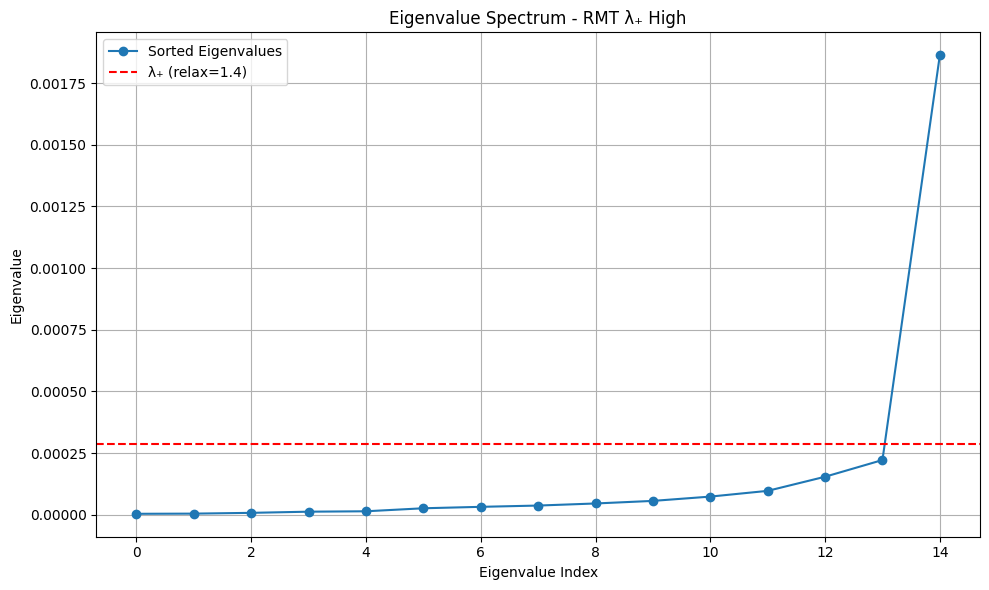

In [19]:
# --- Eigenvalue Spectrum Diagnostic Plot ---
import matplotlib.pyplot as plt
import numpy as np

def plot_eigenvalue_spectrum(returns, relax=1.0, label=""):
    """
    Plot the sorted eigenvalues of the sample covariance matrix,
    along with the Marčenko–Pastur λ₊ threshold.
    """
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals = np.sort(np.linalg.eigvalsh(sample_cov))  # sorted ascending

    # Calculate Marčenko–Pastur threshold
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals, marker='o', label='Sorted Eigenvalues')
    plt.axhline(y=lambda_plus, color='red', linestyle='--', label=f'λ₊ (relax={relax})')
    plt.title(f"Eigenvalue Spectrum - {label}")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"eigenvalue_spectrum_{label.replace(' ', '_').replace('λ₊', 'lambda')}.png", dpi=300)
    plt.show()

# Use training set from last regime to ensure consistency
last_train_start, last_train_end, _, _ = regimes[-1]
last_train_prices = prices.loc[last_train_start:last_train_end]
last_train_returns = last_train_prices.pct_change().dropna()

# Plot for RMT λ₊ Base and High
plot_eigenvalue_spectrum(last_train_returns, relax=1.0, label="RMT λ₊ Base")
plot_eigenvalue_spectrum(last_train_returns, relax=1.4, label="RMT λ₊ High")